In [1]:
import numpy as np
from numba import jit,njit
import matplotlib.pyplot as plt
import cv2
import time
from sklearn.preprocessing import normalize
from scipy import signal
from scipy import sparse
import skimage
import tifffile as tiff
import os
import math
import operator
from com import *
from skeleton import *
from tqdm.notebook import tqdm


In [2]:
imgspath = r"/media/isis0517/QVO2/200324_male_siedview_3"
#imgspath = "/home/isis0517/Documents/data/imgs"

def getkey(x):
    temp = x.split("_")
    s = int(temp[-1].split(".")[0])
    return (temp[0], s)

flist = os.listdir(imgspath)
flist.sort(key=lambda x: (x[0:2], len(x), x))
print(len(flist))
data_len = len(flist)//2


40000


(500, 2040)


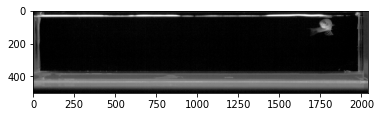

In [54]:
test_frame = np.load(os.path.join(imgspath, flist[2531]))
plt.imshow(test_frame, plt.cm.gray)
print(test_frame.shape)

In [4]:
# video = cv2.VideoWriter("output1.avi", cv2.VideoWriter_fourcc(*"MJPG"), 10, (1200,800))
# for s in tqdm(range(data_len)):
    
#     b = cv2.resize(np.flip(np.load(os.path.join(imgspath, flist[s+data_len]))), (1200,400))
#     b = cv2.cvtColor(b, cv2.COLOR_GRAY2RGB)
#     a = cv2.cvtColor(np.load(os.path.join(imgspath, flist[s])), cv2.COLOR_BAYER_BG2RGB)
#     a = cv2.resize(a, (1200,400))
#     video.write(np.concatenate((b, a), axis=0))
# video.release()
# plt.imshow(a)


In [5]:
# tnum = np.random.randint(data_len,size = int(data_len*0.2))
# a = cv2.cvtColor(np.load(os.path.join(imgspath, flist[s])), cv2.COLOR_BAYER_BG2GRAY)
# back = np.zeros(a.shape)
# for s in tnum:
#     a = cv2.cvtColor(np.load(os.path.join(imgspath, flist[s])), cv2.COLOR_BAYER_BG2GRAY)
#     back += a
# back = back/len(tnum)
# back = back.astype('uint8')

In [6]:
# video = cv2.VideoWriter("output1.avi", cv2.VideoWriter_fourcc(*"MJPG"), 10, (a.shape[1], a.shape[0]), True)
# kernel = np.ones((3,3), np.uint8)
# for s in tqdm(range(data_len)):
#     a = cv2.cvtColor(np.load(os.path.join(imgspath, flist[s])), cv2.COLOR_BAYER_BG2GRAY)
#     diff = ((cv2.absdiff(a, back)>30)*255).astype('uint8')
    
#     diff = cv2.erode(diff, kernel, iterations = 4)
#     diff = cv2.dilate(diff, kernel, iterations = 6)
#     a = cv2.cvtColor(np.load(os.path.join(imgspath, flist[s])), cv2.COLOR_BAYER_BG2RGB)
#     video.write(cv2.bitwise_and(a, a, mask = diff)) #apply mask
    
# video.release()

    
# diff = cv2.dilate(diff, kernel, iterations = 3)
# plt.imshow(diff)
# #cv2.imwrite("test.png", diff)

In [7]:
# labels = label(diff, connectivity=2, background=0)
# group = regionprops(labels, cache=True)

# 找出ZebraPCA

## 產生背景

In [8]:
tnum = np.random.randint(data_len,size = 1000)
a = np.load(os.path.join(imgspath, flist[10+data_len]))
background = np.zeros(a.shape)
for s in tnum:
    a = np.load(os.path.join(imgspath, flist[s+data_len]))
    background += a
background = background/len(tnum)
background = background.astype('uint8')


## 轉正圖片 & 儲存

In [9]:
NT_skeleton(background, di_num=3)


array([[ 465, 1297],
       [ 431, 1190],
       [ 431, 1069],
       [ 431,  948],
       [ 431,  829],
       [ 431,  708],
       [ 431,  587],
       [ 432,  467],
       [ 432,  345],
       [ 464,  240]])

In [10]:
imgs = []
h_ans = []

for s in tqdm(range(data_len)):
    
    img = np.load(os.path.join(imgspath, flist[s+data_len]))
    img = cv2.absdiff(img, background)
    img = np.where(img>120, 255, 0).astype('uint8')
    pos = get_pos(img)
    img = cutting_img(img, pos, 100)
    
    try:
        sk = NT_skeleton(img)
    except Exception as e:
        print(s, e)
        continue
        
    v1 = sk[0]-sk[2]
    a = v1/np.linalg.norm(v1, ord=2)
    b = np.array([1,0])
    c = a-b
    angle = 2*np.arcsin(np.linalg.norm(c/2))
    if a[1]>0:
        angle = -angle
    if angle != angle:
        print("算錯啦")
        print(sk)
    M = cv2.getRotationMatrix2D((100, 100), 180+angle/(np.pi)*180, 1)
    rotated = cv2.warpAffine(img, M, (201,201))
    
    imgs.append(rotated)
    h_ans.append(angle)

  0%|          | 0/20000 [00:00<?, ?it/s]

-0.13706617431018764


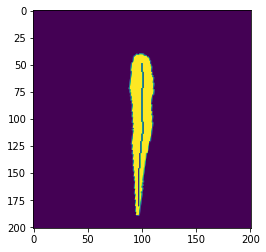

In [11]:
s = 15240
sk = NT_skeleton(imgs[s])

print(h_ans[15240])
draw = imgs[s].copy()
for n in range(len(sk)-1):
    cv2.line(draw, (sk[n, 1], sk[n, 0]), (sk[n+1, 1], sk[n+1, 0]), (0), 1)
plt.imshow(draw)
#plt.plot(*np.flip(sk, axis=1).T, lw=1.3, color='r')
#plt.axis('off')
#plt.imshow(np.load(os.path.join(imgspath, flist[s+data_len])))

### save as video

In [12]:
video = cv2.VideoWriter("output_v.avi", cv2.VideoWriter_fourcc(*"MJPG"), 10, (imgs[0].shape[1], imgs[0].shape[0]), False)

for s, img in enumerate(tqdm(imgs)):
    try :
        sk = NT_skeleton(img)
    except Exception as e:
        print(s, e)
    draw = img.copy()
    for n in range(len(sk)-1):
        cv2.line(draw, (sk[n, 1], sk[n, 0]), (sk[n+1, 1], sk[n+1, 0]), (0), 1)
    video.write(draw)
video.release()

  0%|          | 0/20000 [00:00<?, ?it/s]

## apply the eigenfish

In [13]:
def an2vec(an, r):
    x = np.cos(an)
    y = np.sin(an)
    return r*np.array([x,y])

def get_rot_M(angle):
    a = np.cos(angle)
    b = np.sin(angle)
    return np.array([[a,-b],[b,a]])

def an2ori(an_sk, vec=np.array([0,1]), intens=1):
    test_sk = [vec]
    for i in range(len(an_sk)):
        vec = np.dot(vec,get_rot_M(an_sk[i]*intens))
        test_sk.append(test_sk[-1]+vec)

    return np.array(test_sk)



han_sks=[]

for s, img in enumerate(tqdm(imgs)):
    
    sk = NT_skeleton(img, di_num=5)
    
    vec_sk = []
    for i in range(len(sk)-1):
        vec_sk.append(sk[i+1]-sk[i])
    if len(sk)<10:
        plt.imshow(imgs[s])
        print(s, NT_skeleton(imgs[s]))
        plt.show()
    
    heading = vec_sk[0]
    han_sk=[]
    
    heading = heading/np.linalg.norm(heading)
    for vec in vec_sk[1:]:
        vec = vec/np.linalg.norm(vec)
        a = heading
        b = vec

        #根據和角公式 = sin(a-b) = sina cosb - cosa sinb
        #sin(angle) = a[1]b[0]-a[0]b[1]
        c = a-b
        angle = 2*np.arcsin(np.linalg.norm(c/2))
        if angle != angle:
            print("算錯啦")
            print(s, vec_sk)
        err = a-np.dot(b, get_rot_M(angle))
        if np.linalg.norm(err) > 0.1:
            #print("turning", a, np.dot(b, get_rot_M(-angle)))
            angle=-angle
        han_sk.append(angle)
    n+=1
    han_sks.append(han_sk)
print(len(han_sks))    


  0%|          | 0/20000 [00:00<?, ?it/s]

20000


## find the pca

[0.89865168 0.06015753 0.01157205 0.00945814 0.00638171] 0.9862211012407683


array([-0.33141737,  0.06436103, -0.08956797, -0.12856383,  0.08573964])

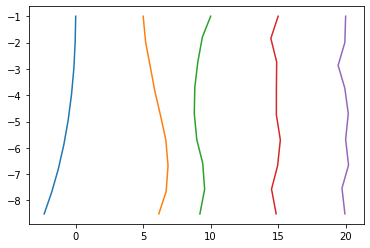

In [14]:

from sklearn.decomposition import PCA
pca = PCA(n_components=5)
pca.fit(han_sks)
pc1 = pca.components_[0]
u = np.array([0,-1])
n=0
for pcs in pca.components_:
    sk = [u]
    pcs = pcs*1
    for an in pcs:
        M = get_rot_M(an).T
        sk.append(sk[-1]+np.dot(M,u))
    sk = np.array(sk)
    plt.plot(sk[:,0]+n*5,sk[:,1])
    n+=1
print(pca.explained_variance_ratio_, np.sum(pca.explained_variance_ratio_))

pca_sks = pca.transform(han_sks)

pca_sks[s]

## apply the Kmeans

In [15]:
from sklearn.cluster import KMeans

n_clusters = 22
kmeans = KMeans(n_clusters=n_clusters, algorithm="elkan", init="k-means++", tol=1e-10, n_init=20)
kmeans.fit(pca_sks)
labels = kmeans.predict(pca_sks)
centers = kmeans.cluster_centers_

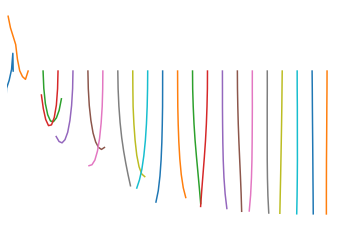

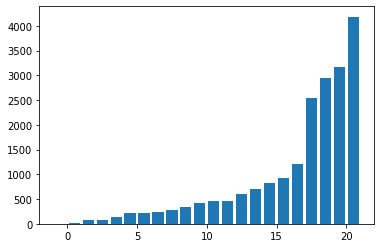

In [16]:
nums, bins = np.histogram(labels, bins=np.arange(n_clusters+1)-0.5)
ords = np.argsort(nums)

for s, pcas in enumerate(centers[ords]):
    sks = np.dot(pcas, pca.components_)
    sk=[np.array([0,-1])]
    for an in sks:
        M = get_rot_M(an).T
        sk.append(sk[-1]+np.dot(M,u))
    sk = np.array(sk)
    plt.plot(sk[:,0]+s*5,sk[:,1])
    n+=1
plt.axis('off')
plt.xlim([-2, n_clusters*5])
plt.show()
plt.bar(bins[:-1], nums[ords])
#plt.axis('off')
plt.show()

0


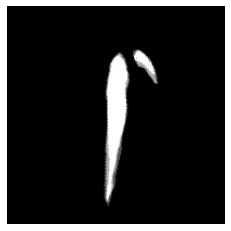

1


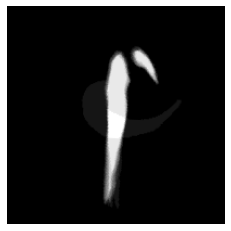

2


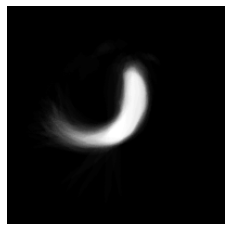

3


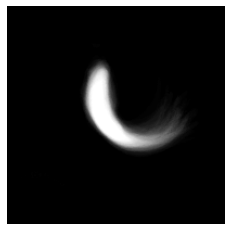

4


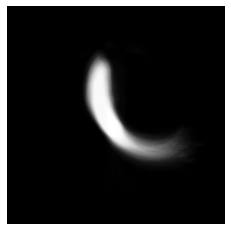

5


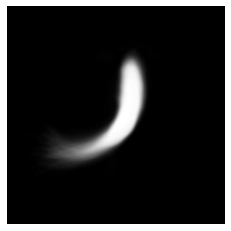

6


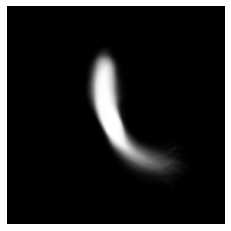

7


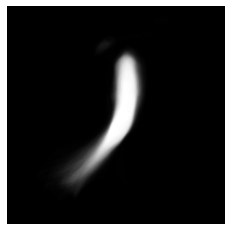

8


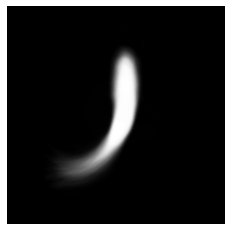

9


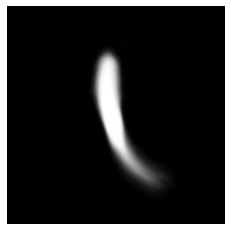

10


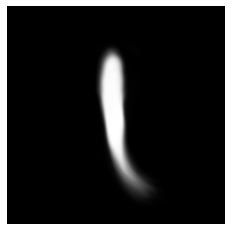

11


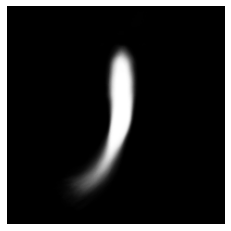

12


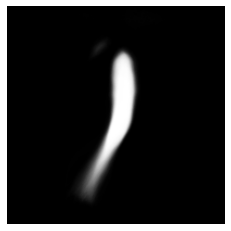

13


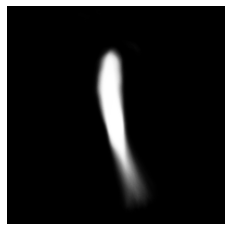

14


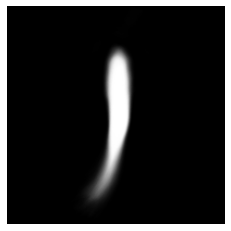

15


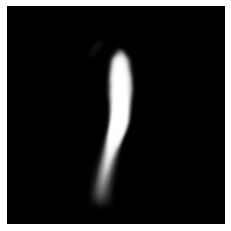

16


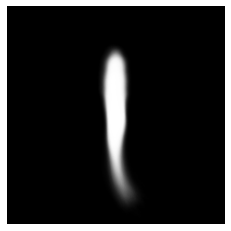

17


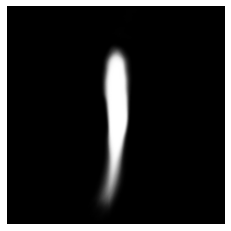

18


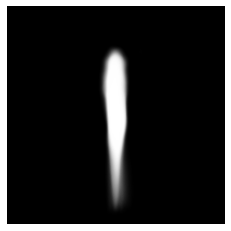

19


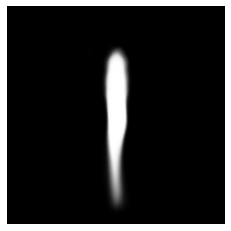

20


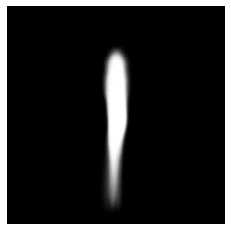

21


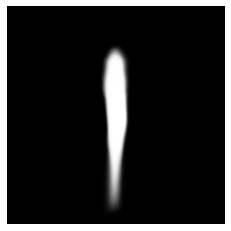

In [17]:
cen_imgs = np.zeros((n_clusters, 201, 201), dtype='int')
for s, label in enumerate(labels[:len(imgs)]):
    cen_imgs[label] += imgs[s]
for s, img in enumerate(cen_imgs[ords]):
    cen_imgs[s] = (img/nums[ords[s]]).astype('uint8')
    print(s)
    #cv2.imwrite(os.path.join(savepath,f"centers_{s}.png"), img*255)
    plt.imshow(cen_imgs[s], plt.cm.gray)
    plt.axis('off')
    plt.show()

In [18]:
_, bins = np.histogram(np.abs(h_ans))
dic_ans = np.digitize(np.abs(h_ans), bins)

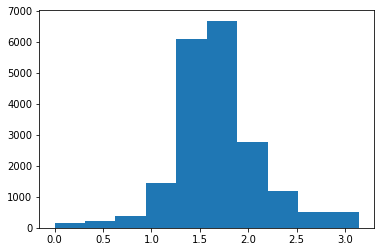

In [19]:
_ = plt.hist(np.abs(h_ans))

# 用 pca + angle 做kmeans

In [84]:
%%time
from sklearn.cluster import KMeans


merge_arr = np.concatenate((np.expand_dims(h_ans, axis=1), pca_sks), axis=1)
n_clusters = 200
kmeans = KMeans(n_clusters=n_clusters, algorithm="elkan", init="k-means++", tol=1e-11, n_init=20)
kmeans.fit(merge_arr)
labels = kmeans.predict(merge_arr)
centers = kmeans.cluster_centers_


CPU times: user 6min 51s, sys: 4min 28s, total: 11min 19s
Wall time: 1min 26s


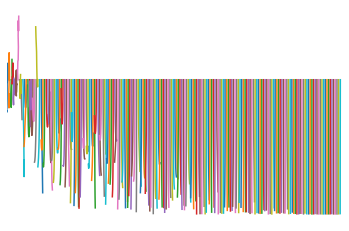

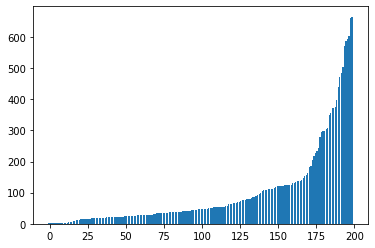

Text(0.5, 0, 'angle')

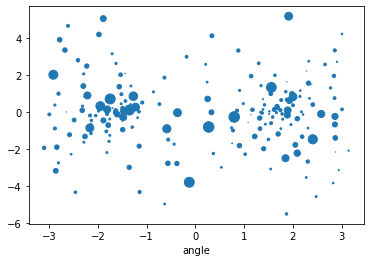

In [85]:
nums, bins = np.histogram(labels, bins=np.arange(n_clusters+1)-0.5)
ords = np.argsort(nums)

for s, pcas in enumerate(centers[ords]):
    sks = np.dot(pcas[1:], pca.components_)
    sk=[np.array([0,-1])]
    for an in sks:
        M = get_rot_M(an).T
        sk.append(sk[-1]+np.dot(M,u))
    sk = np.array(sk)
    plt.plot(sk[:,0]+s*5,sk[:,1])
    n+=1

plt.axis('off')
plt.xlim([-2, n_clusters*5])
plt.show()
plt.bar(bins[:-1], nums[ords])
#plt.axis('off')
plt.show()

plt.scatter(*centers[ords][:,0:2].T, marker="o", s=nums/6)
plt.xlabel("angle")

# 產生對應的side view

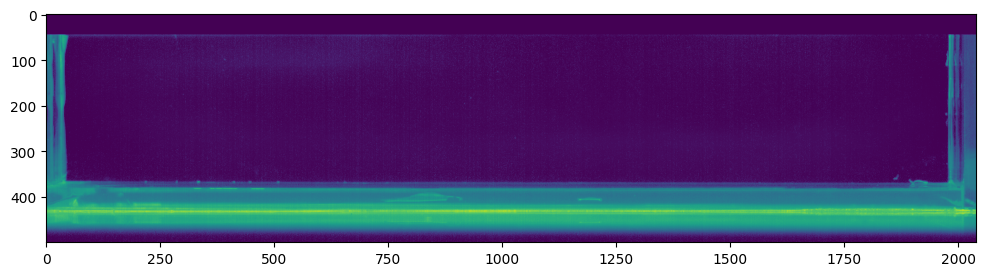

In [39]:
tnum = np.random.randint(data_len,size = int(data_len*0.2))
a = np.load(os.path.join(imgspath, flist[10]))
side_back = np.zeros(a.shape)
for s in tnum:
    a = np.load(os.path.join(imgspath, flist[s]))
    side_back += a
side_back = side_back/len(tnum)
side_back = side_back.astype('uint8')
plt.figure(figsize=(12,8), dpi= 100)
plt.imshow(side_back)

aq_mask = np.full(a.shape, True)
aq_mask[0:45, ...] = False
plt.imshow(side_back*aq_mask)
aq_mask = np.where(aq_mask, 255, 0).astype('uint8')


-0.6


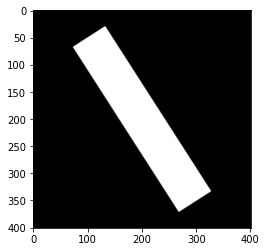

In [23]:

stand = np.zeros((401, 401, 3), dtype=np.uint8)
cv2.rectangle(stand, (20, 165), (380, 235), (255,255,255), -1)
M = cv2.getRotationMatrix2D((200, 200), (1)/(np.pi)*180, 1)
rotated = cv2.warpAffine(stand, M, (401,401))
stands = []
rot_an = []
level_lim = 50
for s in range(level_lim):
    an = (-1+(2*s/level_lim))
    M = cv2.getRotationMatrix2D((200, 200), an/(np.pi)*180, 1)
    stands.append(cv2.warpAffine(stand, M, (401,401)))
    rot_an.append(an)
plt.imshow(stands[10])
print(rot_an[10])

M = cv2.getRotationMatrix2D((200, 200), -rot_an[0]/(np.pi)*180, 1)
plt.imshow(cv2.warpAffine(stands[0], M, (401,401)))
plt.imshow(stands[0])

In [24]:
# sideviews = []
# kernel = np.ones((3,3), np.uint8)
    
# for s in tqdm(range(data_len)):
#     raw = np.load(os.path.join(imgspath, flist[s]))
#     a = cv2.cvtColor(raw, cv2.COLOR_BAYER_BG2GRAY)
#     diff = ((cv2.absdiff(a, side_back)>25)*255).astype('uint8')
#     diff = cv2.bitwise_and(diff, diff, mask = aq_mask) #apply mask
#     diff = cv2.erode(diff, kernel, iterations = 7)
#     diff = cv2.dilate(diff, kernel, iterations = 10)
    
#     a = cv2.cvtColor(raw, cv2.COLOR_BAYER_BG2RGB)
#     side = cv2.bitwise_and(a, a, mask = diff)#apply mask
#     img = cutting_img(side, get_pos(diff), size = 200)
    
#     bacis = []
#     for num, stand in enumerate(stands):
#         bacis.append(np.sum(np.logical_and(img ,stand)))
#     bigarg = np.argmax(bacis)
#     an = -rot_an[bigarg]
#     M = cv2.getRotationMatrix2D((200, 200), an/(np.pi)*180, 1)
#     img = cv2.warpAffine(img, M, (401,401))

#     sideviews.append(img)
    

# #cv2.imwrite("test.png", diff)

## multi ver

In [108]:
%%time
from multiprocessing import Pool
from numba import jit, njit

@jit(nogil=True)
def muti_img(filepath, mask=aq_mask, stands=stands, kernel=np.ones((3,3), np.uint8), rot_an=rot_an):
    
    raw = np.load(filepath)
    a = cv2.cvtColor(raw, cv2.COLOR_BAYER_BG2GRAY)
    diff = ((cv2.absdiff(a, side_back)>25)*255).astype('uint8')
    diff = cv2.bitwise_and(diff, diff, mask = aq_mask) #apply mask
    diff = cv2.erode(diff, kernel, iterations = 1)
    diff = cv2.dilate(diff, kernel, iterations = 7)
    diff = cv2.bitwise_and(diff, diff, mask = aq_mask) #apply mask
    
    a = cv2.cvtColor(raw, cv2.COLOR_BAYER_BG2RGB)
    side = cv2.bitwise_and(a, a, mask = diff)#apply mask
    img = cutting_img(side, get_pos(diff), size = 200)
    
    bacis = [0]*len(stands)
    for num, stand in enumerate(stands):
        bacis[num] = np.sum(np.logical_and(img ,stand))
    bigarg = np.argmax(bacis)
    an = -rot_an[bigarg]
    M = cv2.getRotationMatrix2D((200, 200), an/(np.pi)*180, 1)
    if bacis[bigarg] > 20000:
        img = cv2.warpAffine(img, M, (401,401))
    
#     bacis = [0]*len(stands)
#     for num, stand in enumerate(stands):
#         bacis[num] = np.sum(np.logical_and(img ,stand))
#     bigarg = np.argmax(bacis)
#     an = -rot_an[bigarg]
#     M = cv2.getRotationMatrix2D((200, 200), an/(np.pi)*180, 1)
#     img = cv2.warpAffine(img, M, (401,401))
    
    return img

with Pool() as pool:
    map_arr = []
    for s in range(data_len):
        path = os.path.join(imgspath, flist[s])
        map_arr.append(path)
    print("pool start")
    result = pool.map(muti_img, map_arr, chunksize=20)
sideviews = result

<timed exec>:4: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "muti_img" failed type inference due to: Untyped global name 'cutting_img': Cannot determine Numba type of <class 'function'>

File "<timed exec>", line 17:
<source missing, REPL/exec in use?>

<timed exec>:4: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "muti_img" failed type inference due to: Untyped global name 'cutting_img': Cannot determine Numba type of <class 'function'>

File "<timed exec>", line 17:
<source missing, REPL/exec in use?>

<timed exec>:4: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "muti_img" failed type inference due to: Untyped global name 'cutting_img': Cannot determine Numba type of <class 'function'>

File "<timed exec>", line 17:
<source missing, REPL/exec in use?>



pool start


<timed exec>:4: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "muti_img" failed type inference due to: Untyped global name 'cutting_img': Cannot determine Numba type of <class 'function'>

File "<timed exec>", line 17:
<source missing, REPL/exec in use?>

<timed exec>:4: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "muti_img" failed type inference due to: Untyped global name 'cutting_img': Cannot determine Numba type of <class 'function'>

File "<timed exec>", line 17:
<source missing, REPL/exec in use?>

<timed exec>:4: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "muti_img" failed type inference due to: Untyped global name 'cutting_img': Cannot determine Numba type of <class 'function'>

File "<timed exec>", line 17:
<source missing, REPL/exec in use?>

<timed exec>:4: NumbaWarning: 
Compilation is falling back to ob

<timed exec>:4: NumbaWarning: Code running in object mode won't allow parallel execution despite nogil=True.
/home/isis0517/.local/lib/python3.6/site-packages/numba/core/object_mode_passes.py:152: NumbaWarning: Function "muti_img" was compiled in object mode without forceobj=True, but has lifted loops.

File "<timed exec>", line 7:
<source missing, REPL/exec in use?>

  state.func_ir.loc))
/home/isis0517/.local/lib/python3.6/site-packages/numba/core/ir_utils.py:2119: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'bacis' of function 'muti_img'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<timed exec>", line 20:
<source missing, REPL/exec in use?>

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
/home/isis0517/.local/lib/python3.6/site-packages/numba/core/ir_utils.py:2119: Nu

/home/isis0517/.local/lib/python3.6/site-packages/numba/core/ir_utils.py:2119: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'stands' of function 'muti_img'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<timed exec>", line 20:
<source missing, REPL/exec in use?>

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
/home/isis0517/.local/lib/python3.6/site-packages/numba/core/ir_utils.py:2119: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'bacis' of function 'muti_img'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<timed exec>", line 20:
<source missing, REPL/exec in use?>

  warning

CPU times: user 24.2 s, sys: 27.6 s, total: 51.7 s
Wall time: 5min 11s


20000


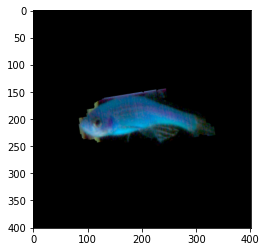

In [109]:

print(len(result))
img = result[6073]

plt.imshow(img)
plt.show()

np.savez("0421-sideviews.npz", sideviews)

In [27]:
class SortSearch:
    def __init__(self, arr):
        self.ords = np.lexsort(arr.T[::-1], axis=-1)
        self.sort_arr = arr[self.ords]
        self.length = len(arr)
        self.inv_ords = np.zeros(self.length, dtype=np.int)
        self.inv_ords[self.ords] = np.arange(self.length, dtype=np.int)
    def find_floor(self, item) -> (int, np.ndarray):
        pass
    def search(self, item, lower=0, upper=None) -> int:
        if upper is None:
            upper = self.length
        item = np.array(item)
        while upper-lower>1:
#             print(f"lower : {lower}, upper : {upper}")
            mid = (lower+upper+1)//2
            com = np.array(self.sort_arr[mid])
            big = item > com
            sma = item < com
            if np.sum(np.logical_xor(big, sma)) == 0:
                upper = mid
                lower = mid
            
            for s in range(len(item)):
                if big[s]:
                    lower = mid
                    break
                elif sma[s]:
                    upper = mid
                    break
            #print(upper, lower)
        return self.ords[lower]
                    
            

## set angle range 

In [28]:
an_mask = np.where(np.logical_and(np.abs(h_ans)>1.2, np.abs(h_ans)<2), 1, 0)
print(an_mask[15240])
merge_arr = np.concatenate((np.expand_dims(an_mask, axis=1), pca_sks), axis=1)
sorter = SortSearch(merge_arr)
print(sorter.ords[:10])
print(sorter.inv_ords[sorter.ords])

0
[ 8508 12456  1578  5648  1474  5464 12460  8848 19264  9580]
[    0     1     2 ... 19997 19998 19999]


In [29]:
print(sorter.sort_arr[:10])

[[ 0.         -5.42378731  0.91358689  0.03363232  0.03871986  0.12231316]
 [ 0.         -5.30927027  0.31263649  0.06767644  0.01889752  0.03174817]
 [ 0.         -5.27090146  0.19667796  0.10994186 -0.0305739   0.06862221]
 [ 0.         -4.97855268  0.08997856 -0.11330533 -0.15661438 -0.02606233]
 [ 0.         -4.8021024   0.67786255  0.08311492 -0.14180905  0.10555539]
 [ 0.         -4.80038919  0.47171348 -0.0547879  -0.08871599 -0.07093379]
 [ 0.         -4.74836714  0.3232578   0.25946322 -0.23301639 -0.15663701]
 [ 0.         -4.70338643  0.52359638  0.12735448  0.04163195  0.11016418]
 [ 0.         -4.61370586  0.10939132  0.02766689  0.079156   -0.00794347]
 [ 0.         -4.60970736  0.84391017 -0.2884509  -0.09869681 -0.05952309]]


# 用 sideview 對應出各個 kmeans center

In [181]:
#%%time
merge_arr = np.concatenate((np.expand_dims(h_ans, axis=1), pca_sks), axis=1)

cen_inds = []

cen_set =  {s:[] for s in range(n_clusters)}
    
for s, label in enumerate(labels):
    cen = centers[label]
    arr = merge_arr[s]
    dis = np.linalg.norm(arr-cen)
    cen_set[label].append((s, dis))
    
for s in range(n_clusters):
    cen_set[s].sort(key=lambda x: x[1])
    
cen_inds = [cen_set[s][0][0] for s in range(n_clusters)]
print(cen_inds[:10])
#ind = 177

class ImgGetor:
    def __init__(self, cen_set, B=1):
        
        for s in range(len(cen_set)):
            cen_set[s].sort(key=lambda x: x[1])
        self.cen_set = cen_set.copy()
        self.cen_probs = []
        self.cen_Qs = []
        for sett in self.cen_set.values():
            Q = 0
            #print(sett)
            length = 10 if len(sett) > 10 else len(sett)
            probs = []
            for s in range(length):
                P = np.exp(-B*(sett[s][1]))
                Q += P
                probs.append((sett[s][0], P))
            self.cen_probs.append(probs)
            self.cen_Qs.append(Q)
    
    def label2img(self, label, rat=1):
        if rat>=1 or rat<0:
            #print("error")
            rat = rat=np.random.rand()
        #print(rat)
        rat = rat*self.cen_Qs[label]
        CP = 0
        for s in self.cen_probs[label]:
            CP += s[1]
            ind = s[0]
            
            if CP > rat:
                break
        #print(self.cen_probs[label])
        return ind
        
geter = ImgGetor(cen_set, B=120)
print(geter.label2img(1))

[10279, 9109, 3823, 4417, 18537, 5287, 4309, 14888, 9896, 9972]
12164


In [173]:
video = cv2.VideoWriter("output_v.avi", cv2.VideoWriter_fourcc(*"MJPG"), 30, (sideviews[0].shape[1], sideviews[0].shape[0]))
for label in labels[:3000]:
    ind = geter.label2img(label)
    img = sideviews[ind].copy()
    img = cv2.putText(img, f"{ind}", (20,20), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (200,200,200), 1)
    video.write(img)
video.release()

# load the other vidoe

this data is hard to get the posture 

['frame_0.npy', 'frame_1.npy', 'frame_2.npy', 'frame_3.npy', 'frame_4.npy', 'frame_5.npy', 'frame_6.npy', 'frame_7.npy', 'frame_8.npy', 'frame_9.npy', 'frame_10.npy', 'frame_11.npy', 'frame_12.npy', 'frame_13.npy', 'frame_14.npy', 'frame_15.npy', 'frame_16.npy', 'frame_17.npy', 'frame_18.npy', 'frame_19.npy']


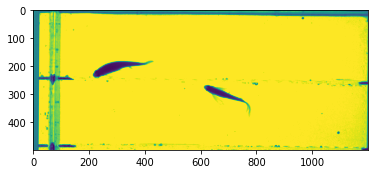

In [32]:
path2 = r"/media/isis0517/QVO2/0419/FaMb1/npy"
flist2 = os.listdir(path2)
temlist = []
for filename in flist2:
    if filename.split(".")[-1] == "npy":
        temlist.append(filename)

temlist.sort(key=lambda x: (x[0:2], len(x), x))
print(temlist[:20])
flist2 = temlist
a = np.load(os.path.join(path2,flist2[0]))
plt.imshow(a)

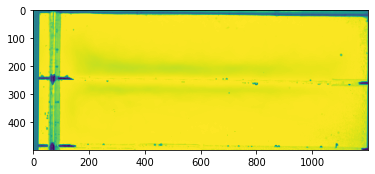

In [33]:

new_background = np.zeros(a.shape)
tnum = np.random.randint(len(flist2), size=int(len(flist2)*0.3))
for s in tnum:
    a = np.load(os.path.join(path2, flist2[s]))
    new_background += a
    
new_background = new_background/len(tnum)
new_background = new_background.astype(np.uint8)
plt.imshow(new_background)

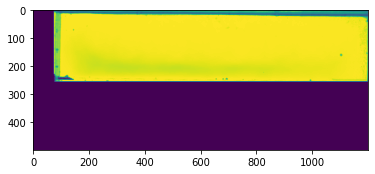

In [34]:
new_mask = np.full(new_background.shape, False)
new_mask[:255, 75:] = True
plt.imshow(new_background*new_mask)

  0%|          | 0/15000 [00:00<?, ?it/s]

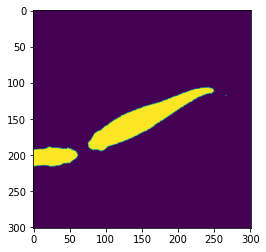

In [37]:
new_imgs = []
new_h_ans = []
new_poses = []
new_han_sks = []
for filename in tqdm(flist2[:]):
    img = np.load(os.path.join(path2, filename))
    img = cv2.absdiff(new_background, img)
    img = np.where(img>80, 255, 0).astype('uint8')
    pos = get_pos(img)
    new_poses.append(pos)
    img = cutting_img(img, pos, 150)
    
    try:
        sk = NT_skeleton(img, er_num=4, di_num=5)
    except Exception as e:
        print(s, e)
        continue
        
    v1 = sk[0]-sk[2]
    a = v1/np.linalg.norm(v1, ord=2)
    b = np.array([-1,0]) # this is the baseline vector
    c = a-b
    angle = 2*np.arcsin(np.linalg.norm(c/2))
    if a[1]>0:
        angle = -angle
    if angle != angle:
        print("算錯啦")
        print(sk)
    h_an = angle
    M = cv2.getRotationMatrix2D((150, 150), 180+h_an/(np.pi)*180, 1)
    rotated = cv2.warpAffine(img, M, (301,301))

    
    vec_sk = []
    for i in range(len(sk)-1):
        vec_sk.append(sk[i+1]-sk[i])
    
    heading = vec_sk[0]
    han_sk=[]
    
    heading = heading/np.linalg.norm(heading)
    for vec in vec_sk[1:]:
        vec = vec/np.linalg.norm(vec)
        a = heading
        b = vec

        #根據和角公式 = sin(a-b) = sina cosb - cosa sinb
        #sin(angle) = a[1]b[0]-a[0]b[1]
        c = a-b
        angle = 2*np.arcsin(np.linalg.norm(c/2))
        if angle != angle:
            print("算錯啦")
            print(filename, vec_sk)
            draw = img.copy()
            cv2.circle(draw, (sk[0, 1], sk[0, 0]), 2, (0), -1)
            for n in range(len(sk)-1):
                cv2.line(draw, (sk[n, 1], sk[n, 0]), (sk[n+1, 1], sk[n+1, 0]), (0), 1)
            plt.imshow(draw)
            plt.show()
            continue
        err = a-np.dot(b, get_rot_M(angle))
        if np.linalg.norm(err) > 0.1:
            #print("turning", a, np.dot(b, get_rot_M(-angle)))
            angle=-angle
        han_sk.append(angle)
    n+=1    
    new_h_ans.append(-h_an)
    new_imgs.append(rotated)
    new_han_sks.append(han_sk)
    
    
plt.imshow(rotated)

[2.0214576528755304, 1.9720251257997454, 1.9100889412489412, 1.9614033704925833, 2.046491545649889, 2.0591302778513025, 2.1206495094714812, 2.0724003809840172, 2.046491545649889, 2.0701430484750265, 2.0591302778513025, 2.0931997585114255, 2.0701430484750265, 2.143762469683603, 2.356194490192345, 2.8753406044388674, -2.819842099193151, -2.7233683240105644, -2.837081770387682, -2.8632929945846826, -2.785956769289032, -2.8112952987605397, -2.837081770387682, -2.8555412118724766, -2.8450468445200925, -2.8526172435972277, -2.8632929945846826, -2.8899026818316065, -2.8966139904629276, -2.6909313275091606, -2.0591302778513025, -2.0344439357957027, -1.9460671496508541, -1.8224862985530834, -1.856847768512215, -1.919567330378804, -1.8836975546752812, -1.892546881191539, -1.8836975546752812, -1.7955074952095396, -1.7405746007632348, -1.8736811951698678, -1.9018924034990283, -1.929566997065469, -1.892546881191539, -1.929566997065469, -1.8086322542523476, -1.7454685258031362, -1.8086322542523476, 

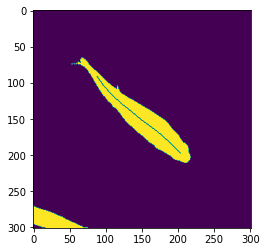

In [89]:
s = 11603
img = np.load(os.path.join(path2, flist2[s]))
img = cv2.absdiff(new_background, img)
img = np.where(img>60, 255, 0).astype('uint8')
pos = get_pos(img)
new_poses.append(pos)
img = cutting_img(img, pos, 150)
sk = NT_skeleton(img, er_num=5, di_num=4)

draw = img.copy()
for n in range(len(sk)-1):
    cv2.line(draw, (sk[n, 1], sk[n, 0]), (sk[n+1, 1], sk[n+1, 0]), (0), 1)
    
vec_sk = []
for i in range(len(sk)-1):
    vec_sk.append(sk[i+1]-sk[i])

heading = vec_sk[0]
han_sk=[]

heading = heading/np.linalg.norm(heading)
for vec in vec_sk[1:]:
    vec = vec/np.linalg.norm(vec)
    a = heading
    b = vec

    #根據和角公式 = sin(a-b) = sina cosb - cosa sinb
    #sin(angle) = a[1]b[0]-a[0]b[1]
    c = a-b
    angle = 2*np.arcsin(np.linalg.norm(c/2))
    if angle != angle:
        print("算錯啦")
        print(filename, vec_sk)
        draw = imgs.copy()
        for n in range(len(sk)-1):
            cv2.line(draw, (sk[n, 1], sk[n, 0]), (sk[n+1, 1], sk[n+1, 0]), (0), 1)
        plt.imshow(draw)
        continue
    err = a-np.dot(b, get_rot_M(angle))
    if np.linalg.norm(err) > 0.1:
        #print("turning", a, np.dot(b, get_rot_M(-angle)))
        angle=-angle
    han_sk.append(angle)
plt.imshow(draw)
#plt.plot(*np.flip(sk, axis=1).T, lw=1.3, color='r')
#plt.axis('off')
#plt.imshow(np.load(os.path.join(imgspath, flist[s+data_len])))


  0%|          | 0/3000 [00:00<?, ?it/s]

267 [[ 76 149]
 [163 150]
 [249 144]
 [267 134]
 [268 133]
 [269 132]
 [270 132]
 [271 131]
 [267 134]]


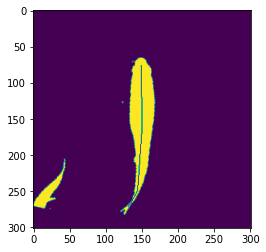

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide


算錯啦
1745 [array([95,  3]), array([38, 71]), array([ 1, -2]), array([0, 1]), array([ 1, -1]), array([ 1, -2]), array([0, 1]), array([-4,  3]), array([0, 0])]
3000


In [51]:
def an2vec(an, r):
    x = np.cos(an)
    y = np.sin(an)
    return r*np.array([x,y])

def get_rot_M(angle):
    a = np.cos(angle)
    b = np.sin(angle)
    return np.array([[a,-b],[b,a]])

def an2ori(an_sk, vec=np.array([0,1]), intens=1):
    test_sk = [vec]
    for i in range(len(an_sk)):
        vec = np.dot(vec,get_rot_M(an_sk[i]*intens))
        test_sk.append(test_sk[-1]+vec)

    return np.array(test_sk)



new_han_sks=[]

for s, img in enumerate(tqdm(new_imgs)):
    
    sk = NT_skeleton(img)
    
    vec_sk = []
    for i in range(len(sk)-1):
        vec_sk.append(sk[i+1]-sk[i])
    if len(sk)<10:
        plt.imshow(img)
        print(s, sk)
        draw = img.copy()
        for n in range(len(sk)-1):
            cv2.line(draw, (sk[n, 1], sk[n, 0]), (sk[n+1, 1], sk[n+1, 0]), (0), 1)
        plt.imshow(draw)
        plt.show()
    
    heading = vec_sk[0]
    han_sk=[]
    
    heading = heading/np.linalg.norm(heading)
    for vec in vec_sk[1:]:
        vec = vec/np.linalg.norm(vec)
        a = heading
        b = vec

        #根據和角公式 = sin(a-b) = sina cosb - cosa sinb
        #sin(angle) = a[1]b[0]-a[0]b[1]
        c = a-b
        angle = 2*np.arcsin(np.linalg.norm(c/2))
        if angle != angle:
            print("算錯啦")
            print(s, vec_sk)
        err = a-np.dot(b, get_rot_M(angle))
        if np.linalg.norm(err) > 0.1:
            #print("turning", a, np.dot(b, get_rot_M(-angle)))
            angle=-angle
        han_sk.append(angle)
    n+=1
    new_han_sks.append(han_sk)
print(len(new_han_sks))    

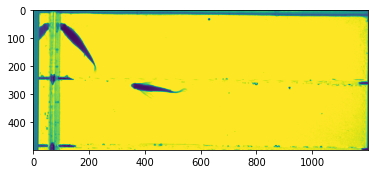

In [52]:
s = 2981
img = np.load(os.path.join(path2, flist2[s]))
plt.imshow(img)

In [197]:
%%time
new_pca_sks = pca.transform(new_han_sks)
new_merge_arr = np.concatenate((np.expand_dims(new_h_ans, axis=1), new_pca_sks), axis=1)
new_labels = kmeans.predict(new_merge_arr)
back = np.zeros((side_back.shape[0], side_back.shape[1], 3), dtype='uint8')
geter = ImgGetor(cen_set, B=6000)

video = cv2.VideoWriter("output_new.avi", cv2.VideoWriter_fourcc(*"MJPG"), 30, (side_back.shape[1], side_back.shape[0]))

for s in range(30):
    img = np.full((side_back.shape[0], side_back.shape[1], 3), 255, dtype='uint8')
    #print(img.shape)
    video.write(img)

video_poses = []
    
rand_ints = np.random.rand(len(new_labels))
for s, label in enumerate(tqdm(new_labels)):
    ind = geter.label2img(label, rat=rand_ints[s])
    img = sideviews[ind].copy()
    pos = (200, int((new_poses[s][1]/new_background.shape[1])*side_back.shape[1]//10*8 + 100 ))
    img = glue_img(img, pos, back)
    img = cv2.putText(img, f"{ind}", (20,20), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (200,200,200), 1)
    video.write(img)
    video_poses.append(pos)
    
    
for s in range(30):
    img = np.full((side_back.shape[0], side_back.shape[1], 3), 255, dtype='uint8')
    #print(img.shape)
    video.write(img)
    
video.release()

np.save(video_poses, "video_poses")
print(len(set(new_labels)))

  0%|          | 0/15000 [00:00<?, ?it/s]

TypeError: expected str, bytes or os.PathLike object, not list

<timed exec>:4: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "muti_img" failed type inference due to: Untyped global name 'cutting_img': Cannot determine Numba type of <class 'function'>

File "<timed exec>", line 17:
<source missing, REPL/exec in use?>

<timed exec>:4: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "muti_img" failed type inference due to: Untyped global name 'cutting_img': Cannot determine Numba type of <class 'function'>

File "<timed exec>", line 17:
<source missing, REPL/exec in use?>

/home/isis0517/.local/lib/python3.6/site-packages/numba/core/object_mode_passes.py:152: NumbaWarning: Function "muti_img" was compiled in object mode without forceobj=True, but has lifted loops.

File "<timed exec>", line 7:
<source missing, REPL/exec in use?>

  state.func_ir.loc))
/home/isis0517/.local/lib/python3.6/site-packages/numba/core/object_mode_passes.py:162: Numba

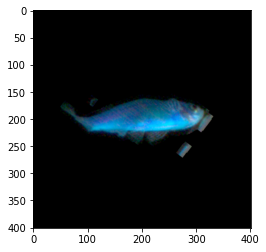

In [198]:
plt.imshow(np.load(os.path.join(imgspath, flist[8759])))
img = muti_img(os.path.join(imgspath, flist[8759]))
plt.imshow(img)
np.save("video_poses", video_poses)


# another vidoe

23430


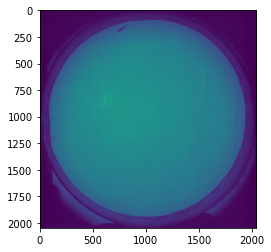

In [42]:
path2 = r"/media/isis0517/QVO2/0115/03"

flist2 = os.listdir(path2)
temlist = []
for filename in flist2:
    if filename.split(".")[-1] == "npy":
        temlist.append(filename)

temlist.sort(key=lambda x: (x[0:2], len(x), x))
print(len(temlist))
flist2 = temlist[:-100]
img = np.load(os.path.join(path2,flist2[0]))
#img = (img/255)**0.6*255
plt.imshow(img)

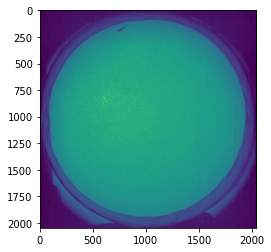

In [43]:
gamma = 0.7
lookUpTable = np.empty((1,256), np.uint8)
for i in range(256):
    lookUpTable[0,i] = np.clip(pow(i / 255.0, gamma) * 255.0, 0, 255)
res = cv2.LUT(img, lookUpTable)
plt.imshow(res)

In [44]:
new_background = np.zeros(img.shape, dtype=np.float)
tnum = np.random.randint(len(flist2), size=int(len(flist2)*0.2))
for s in tqdm(tnum):
    img = np.load(os.path.join(path2, flist2[s]))
    img = cv2.LUT(img, lookUpTable)
    img = cv2.blur(img, (5, 5))
    new_background += img
    
new_background = new_background / len(tnum)
new_background = new_background.astype(np.uint8)
plt.imshow(new_background)

  0%|          | 0/4666 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
new_imgs = []
for filename in tqdm(flist2):
    img = np.load(os.path.join(path2, filename))
    img = cv2.LUT(img, lookUpTable)
    img = img.astype(np.uint8)
    img = cv2.blur(img, (5, 5))
    img = cv2.absdiff(new_background, img)
    img = np.where(img>30, 255, 0).astype('uint8')
    pos = get_pos(img)
    img = cutting_img(img, pos, 100)
    new_imgs.append(img)
plt.imshow(img)

In [ ]:
now_roteds = []
new_h_ans = []

for img in tqdm(new_imgs):
    try:
        sk = NT_skeleton(img)
    except Exception as e:
        print(s, e)
        continue
        
    v1 = sk[0]-sk[2]
    a = v1/np.linalg.norm(v1, ord=2)
    b = np.array([1,0])
    c = a-b
    angle = 2*np.arcsin(np.linalg.norm(c/2))
    if a[1]>0:
        angle = -angle
    if angle != angle:
        print("算錯啦")
        print(sk)
    M = cv2.getRotationMatrix2D((100, 100), 180+angle/(np.pi)*180, 1)
    rotated = cv2.warpAffine(img, M, (201,201))
    
    now_roteds.append(rotated)
    new_h_ans.append(angle)

In [ ]:

new_han_sks=[]

for s, img in enumerate(tqdm(now_roteds)):
    
    sk = NT_skeleton(img, di_num=5)
    
    vec_sk = []
    for i in range(len(sk)-1):
        vec_sk.append(sk[i+1]-sk[i])
    if len(sk)<10:
        plt.imshow(imgs[s])
        print(s, NT_skeleton(imgs[s]))
        plt.show()
    
    heading = vec_sk[0]
    han_sk=[]
    
    heading = heading/np.linalg.norm(heading)
    for vec in vec_sk[1:]:
        vec = vec/np.linalg.norm(vec)
        a = heading
        b = vec

        #根據和角公式 = sin(a-b) = sina cosb - cosa sinb
        #sin(angle) = a[1]b[0]-a[0]b[1]
        c = a-b
        angle = 2*np.arcsin(np.linalg.norm(c/2))
        if angle != angle:
            print("算錯啦")
            print(s, vec_sk)
        err = a-np.dot(b, get_rot_M(angle))
        if np.linalg.norm(err) > 0.1:
            #print("turning", a, np.dot(b, get_rot_M(-angle)))
            angle=-angle
        han_sk.append(angle)
    n+=1
    new_han_sks.append(han_sk)
print(len(new_han_sks))    


In [ ]:
new_pca_sks = pca.transform(new_han_sks)
new_merge_sks = np.concatenate((np.ones((len(new_pca_sks),1)), new_pca_sks), axis=1)
sorter.search(new_merge_sks[0])

In [ ]:
video = cv2.VideoWriter("output_v.avi", 0, 30, (sideviews[0].shape[1], sideviews[0].shape[0]))
for sks in tqdm(new_merge_sks[:3000]):
    ind = sorter.search(sks)
    if ind == 18483:
        print(sks, merge_arr[18483])
        break
    img = sideviews[ind].copy()
    img = cv2.putText(img, f"{ind}", (20,20), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (200,200,200), 1)
    video.write(img)
video.release()

# t-sne

In [4]:

%%time
loadding = np.load("0419-sideviews.npz")

sideviews = loadding["arr_0"]

from sklearn import manifold

X = [cv2.cvtColor(x, cv2.COLOR_RGB2GRAY).flatten() for x in sideviews]
Tsne = manifold.TSNE(n_components=2, init='random', verbose=2)
t_lables = Tsne.fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 20000 samples in 1.774s...
[t-SNE] Computed neighbors for 20000 samples in 509.534s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20000
[t-SNE] Computed conditional probabilities for sample 2000 / 20000
[t-SNE] Computed conditional probabilities for sample 3000 / 20000
[t-SNE] Computed conditional probabilities for sample 4000 / 20000
[t-SNE] Computed conditional probabilities for sample 5000 / 20000
[t-SNE] Computed conditional probabilities for sample 6000 / 20000
[t-SNE] Computed conditional probabilities for sample 7000 / 20000
[t-SNE] Computed conditional probabilities for sample 8000 / 20000
[t-SNE] Computed conditional probabilities for sample 9000 / 20000
[t-SNE] Computed conditional probabilities for sample 10000 / 20000
[t-SNE] Computed conditional probabilities for sample 11000 / 20000
[t-SNE] Computed conditional probabilities for sample 12000 / 20000
[t-SNE] Computed conditional probabilities for s

8756


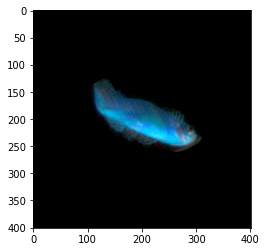

8757


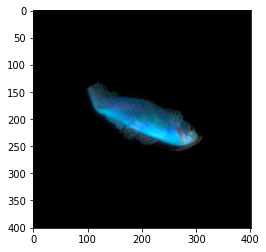

8758


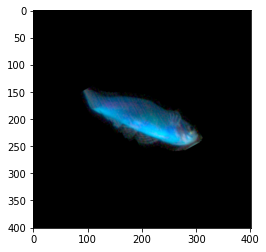

8759


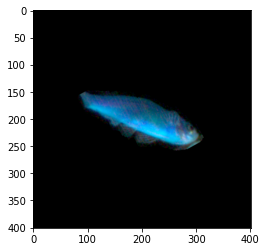

8760


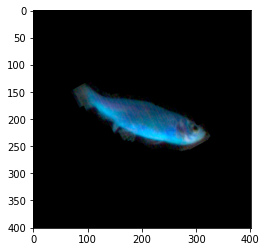

18536


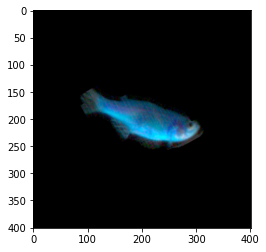

[ 71.14772 -37.9313 ]


In [25]:
#plt.scatter(*t_lables.T, s=0.1)

arr = []

for s, label in enumerate(t_lables):
    if label[0]<72 and label[0]>71 and label[1]<-37 and label[1]>-38:
        arr.append(s)
        print(s)
        plt.imshow(sideviews[s])
        plt.show()
print(t_lables[8759])